In [ ]:
# импортируем зависимости
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from catboost import CatBoostRegressor, Pool
from sklearn import datasets, manifold, model_selection, preprocessing, cluster, metrics, linear_model
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

     |████████████████████████████████| 65.9MB 42kB/s 
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Загрузка

In [ ]:
df = pd.read_csv("/content/drive/My Drive/gb classic/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/gb classic/test.csv")
df_test.head(50)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [ ]:
df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

# Houseyear & categorical

In [ ]:
df_one_hot = df.replace({"Ecology_2": {"A": 0, "B": 1}, "Ecology_3": {"A": 0, "B": 1}, "Shops_2": {"A": 0, "B": 1}})

df_vibros_year = df_one_hot.copy(deep=True)
df_vibros_part = df_vibros_year['HouseYear'][(df_vibros_year['HouseYear'] < 1900) | (df_vibros_year['HouseYear'] > 2020)]
df_vibros_year['HouseYear'][(df_vibros_year['HouseYear'] < 1900) | (df_vibros_year['HouseYear'] > 2020)] = [df_vibros_year['HouseYear'].median() for i in range(len(df_vibros_part))]

df_vibros_year
year_median = df_vibros_year['HouseYear'].median()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
pd.concat([df_vibros_square.loc[df_vibros_square['LifeSquare'].isnull()].median(),
           df_vibros_square.loc[df_vibros_square['LifeSquare'].isnull() == False].median(),
           df_vibros_square.loc[df_vibros_square['LifeSquare']/df_vibros_square['Square'] > 0.8].median(),
           df_vibros_square.loc[(df_vibros_square['LifeSquare']/df_vibros_square['Square']).between(0.4, 0.8)].median()], axis=1)

,0,1,2,3
Id,NaN,8394.500000,8528.000000,8388.500000
DistrictId,NaN,36.000000,27.000000,42.000000
Rooms,NaN,2.000000,2.000000,2.000000
Square,NaN,52.633651,57.557227,51.858662
LifeSquare,NaN,33.495930,54.561508,32.187122
KitchenSquare,NaN,6.000000,1.000000,6.000000
Floor,NaN,7.000000,9.000000,7.000000
HouseFloor,NaN,13.000000,17.000000,12.000000
HouseYear,NaN,1977.000000,2014.000000,1977.000000
Ecology_1,NaN,0.075424,0.072158,0.075779


# LifeSquare

2113 7887 32.781260192155735


(array([9.992e+03, 4.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([6.00064399e-03, 3.05806637e+00, 6.11013210e+00, 9.16219783e+00,
        1.22142636e+01, 1.52663293e+01, 1.83183950e+01, 2.13704608e+01,
        2.44225265e+01, 2.74745922e+01, 3.05266579e+01, 3.35787237e+01,
        3.66307894e+01, 3.96828551e+01, 4.27349209e+01, 4.57869866e+01,
        4.88390523e+01, 5.18911181e+01, 5.49431838e+01, 5.79952495e+01,
        6.10473152e+01, 6.40993810e+01, 6.71514467e+01, 7.02035124e+01,
        7.32555782e+01, 7.63076439e+01, 7.93597096e+01, 8.24117754e+01,
        8.54638411e+01, 8.85159068e+01, 9.15679725e+01]),
 <a list of 30 Patch objects>)

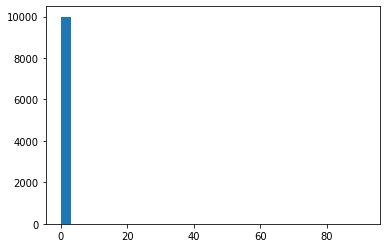

In [ ]:

df_vibros_square = df_vibros_year.copy()
df_vibros_part = df_vibros_square[df_vibros_square['LifeSquare'].isnull()]['LifeSquare'].index.values
df_normal_part = df_vibros_square[df_vibros_square['LifeSquare'].notnull()]['LifeSquare']

# df_vibros_square["notLife"] = df_vibros_square['LifeSquare'].isna()
# df_vibros_square.loc[df_vibros_part, 'LifeSquare'] = [df_normal_part.median() for i in range(len(df_vibros_part))]
df_vibros_square.loc[df_vibros_square['LifeSquare'].isnull(), 'LifeSquare'] = df_vibros_square[df_vibros_square['LifeSquare'].isnull()]['Square']*0.65
print(len(df_vibros_part), len(df_normal_part), df_normal_part.median())


plt.hist((df_vibros_square[df_vibros_square['LifeSquare'].notnull()]['LifeSquare'])/(df_vibros_square[df_vibros_square['LifeSquare'].notnull()]['Square']), bins=30)
# print(df_vibros_square['LifeSquare'].head(50))
# df_vibros_square["notLife"] = df_vibros_square['LifeSquare'] == 0
# print(df_vibros_square[["notLife", 'LifeSquare']].head(50))

In [ ]:
# df_vibros_part = df_vibros_square[df_vibros_square['LifeSquare'].isnull()]
# df_normal_part = df_vibros_square[df_vibros_square['LifeSquare'].notnull()]

# X, X_test, y, y_test = model_selection.train_test_split(df_normal_part[["Square", "Rooms", "KitchenSquare", "DistrictId", 'LifeSquare']], df_normal_part['LifeSquare'], test_size=0.2, random_state=44)

# # X["life_k"] = X.groupby("DistrictId").agg({"Square": np.median, 'LifeSquare', np.median}).reset_index()
# X.head()
# X_gr = X.groupby("DistrictId").agg({"Square": np.median, 'LifeSquare': np.median})
# X_k  = pd.DataFrame({"life_k": X_gr['LifeSquare']/X_gr['Square'], "life_s": X_gr['LifeSquare']}).reset_index()
# X_k
# X = pd.merge(X, X_k, how="left", on="DistrictId")
# X_test = pd.merge(X_test, X_k, how="left", on="DistrictId")
# df_vibros_part = pd.merge(df_vibros_part, X_k, how="left", on="DistrictId")
# X_test.fillna(X["life_k"].median(), inplace=True)
# X_test.fillna(X["life_s"].median(), inplace=True)
# df_vibros_part["life_k"].fillna(X["life_k"].median(), inplace=True)
# df_vibros_part["life_s"].fillna(X["life_s"].median(), inplace=True)
# print(X_test.isnull().sum())
# print(df_vibros_part.isnull().sum())
# print(X_test)
# # plt.scatter(X_test["life_k"], X_test['LifeSquare']/X_test['Square'])


# model = RandomForestRegressor(
#                           n_estimators=200,
#                           max_depth=7
#                           )

# # model = linear_model.LinearRegression(normalize=True)

# model.fit(X = np.array(X.drop(columns=["DistrictId", 'LifeSquare']), float),
#                       y = np.array(y, float))
            
# score_ = metrics.r2_score(y_test, model.predict(X_test.drop(columns=["DistrictId", 'LifeSquare'])))
# print(score_)
# print(pd.DataFrame(model.feature_importances_, index=X.drop(columns=["DistrictId", 'LifeSquare']).columns).sort_values(by=0))

# model_na = RandomForestRegressor(
#                           n_estimators=200,
#                           max_depth=7
#                           )

# model_na.fit(X = np.array(df_normal_part[["Square", "Rooms", "KitchenSquare", "DistrictId"]], float),
#                       y = np.array(df_normal_part['LifeSquare'], float))

# print(model_na.predict(np.array(df_vibros_part[["Square", "Rooms", "KitchenSquare", "DistrictId"]], float)), model_na.predict(np.array(df_vibros_part[["Square", "Rooms", "KitchenSquare", "DistrictId"]], float)).shape)             
# df_vibros_square.loc[df_vibros_square[df_vibros_square['LifeSquare'].isnull()].index.values, 'LifeSquare'] = model_na.predict(np.array(df_vibros_part[["Square", "Rooms", "KitchenSquare", "DistrictId"]], float))
# df_vibros_square.isnull().sum()

Square           0
Rooms            0
KitchenSquare    0
DistrictId       0
LifeSquare       0
life_k           0
life_s           0
dtype: int64
Id               0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
DistrictId       0
life_k           0
life_s           0
dtype: int64
         Square  Rooms  KitchenSquare  ...  LifeSquare    life_k     life_s
0     63.977918    2.0           10.0  ...   36.612384  0.527698  24.271030
1     30.670970    1.0            6.0  ...   17.255218  0.633650  28.619983
2     55.225358    2.0            9.0  ...   33.573348  0.676155  37.387041
3     43.956044    2.0           19.0  ...   10.523868  0.676155  37.387041
4     45.787482    1.0            1.0  ... 

KeyboardInterrupt: ignored

# Helthcare1

In [ ]:
def indent_model(train_df):
  model = RandomForestClassifier(max_depth = 15)
  train_ = train_df[train_df['Healthcare_1'].isna() == False][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']]
  tr, tst = model_selection.train_test_split(train_, test_size=0.15, random_state=44)
  model.fit(tr.drop(columns=['Healthcare_1']), tr['Healthcare_1'])
  pred = model.predict(tst.drop(columns=['Healthcare_1']))
  print(metrics.accuracy_score(tst['Healthcare_1'], pred))
  test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']]
  model.fit(train_.drop(columns=['Healthcare_1']), train_['Healthcare_1'])
  pred = model.predict(test_.drop(columns=['Healthcare_1']))
  print(len(pred))
  return pred


In [ ]:
df_vibros_health = df_vibros_square.copy()

df_vibros_health.loc[df_vibros_health['Healthcare_1'].isna(), 'Healthcare_1'] = indent_model(df_vibros_health)

df_vibros_health.isnull().sum()

0.998719590268886
4798


Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

# districtId to median

In [ ]:
df_vibros_district = df_vibros_health
X_gr = df_vibros_district.groupby("DistrictId").agg({"Square": np.median, 'Price': np.median})
X_k  = pd.DataFrame({"life_k": X_gr['Price']/X_gr['Square'], "life_s": X_gr['Price']}).reset_index()
df_vibros_district = pd.merge(df_vibros_district, X_k, how="left", on="DistrictId")
df_vibros_district.fillna(df_vibros_district["life_k"].median(), inplace=True)
df_vibros_district.fillna(df_vibros_district["life_s"].median(), inplace=True)
df_vibros_district.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,life_k,life_s
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,1,1,33,7976,5,990.0,0,11,1,184966.930730,4273.980146,203602.408898
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,1,1,46,10309,1,240.0,1,16,1,300009.450063,4395.277115,210694.850106
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968.0,0.049637,1,1,34,7759,0,229.0,1,3,1,220925.908524,4527.229293,245978.794474
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977.0,0.437885,1,1,23,5735,3,1084.0,0,5,1,175616.227217,2955.306014,151557.904767
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,1,1,35,5776,1,2078.0,2,4,1,150226.531644,3942.103724,178829.166450


# polinomial features

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

df_pol_f = df_vibros_district
column_imp = ['LifeSquare', 'Square', 'life_s', 'life_k', 'Rooms']
poly = PolynomialFeatures(degree=2, include_bias=False)
print(df_pol_f.drop(columns=column_imp))
print(pd.DataFrame(poly.fit_transform(df_pol_f[column_imp])), pd.DataFrame(poly.fit_transform(df_pol_f[column_imp])).shape)
# print(pd.concat([df_pol_f.drop(columns=column_imp).reset_index(drop=True), pd.DataFrame(poly.fit_transform(df_pol_f[column_imp]))], axis=1).head(15))
# df_pol_f = pd.concat([df_pol_f.reset_index(drop=True), pd.DataFrame(poly.fit_transform(df_pol_f[column_imp])).drop(columns=[0, 1, 2, 3, 4])], axis=1)
df_pol_f = pd.concat([df_pol_f.reset_index(drop=True), pd.DataFrame(poly.fit_transform(df_pol_f[column_imp]))[[11, 12]]], axis=1)

         Id  DistrictId  KitchenSquare  ...  Shops_1  Shops_2          Price
0     14038          35            6.0  ...       11        1  184966.930730
1     15053          41            8.0  ...       16        1  300009.450063
2      4765          53            0.0  ...        3        1  220925.908524
3      5809          58            9.0  ...        5        1  175616.227217
4     10783          99            7.0  ...        4        1  150226.531644
...     ...         ...            ...  ...      ...      ...            ...
9995     77          32            5.0  ...       11        1  196684.316040
9996   6159          18            9.0  ...        5        0  189050.289571
9997   5123          27            1.0  ...        0        0  159143.805370
9998   5400          75            8.0  ...        5        1  181595.339808
9999   6306         128            8.0  ...        8        1  218714.077615

[10000 rows x 17 columns]
             0          1              2   ...   

# fit model

In [ ]:
X, X_test, y, y_test = model_selection.train_test_split(df_pol_f.drop(columns=["Price", "Id", "DistrictId", 'Shops_2', 'Ecology_2', 'Ecology_3']), df_vibros_district["Price"], test_size=0.22, random_state=144)

In [ ]:
score = {}

for max_features in np.arange(2, 18, 2):
  train_dir = f"ma_depth={max_features}"
  model = RandomForestRegressor(
                          n_estimators=250,
                          max_depth=30,
                          max_features = max_features,
                          criterion="mse"
                          )

  model.fit(X = np.array(X, float),
                      y = np.array(y, float))
            
  score_ = metrics.r2_score(y_test, model.predict(X_test))
  score[train_dir]=score_
  print(model.score(np.array(X_test, float), np.array(y_test, float)))
  print(train_dir)
  print(score_)
            

score = pd.Series(score)
print(pd.DataFrame(model.feature_importances_, index=X.columns).sort_values(by=0))
importnat_f = pd.DataFrame(model.feature_importances_, index=X.columns).sort_values(by=0, ascending=False)[:15].reset_index()
print(importnat_f)
print(score.sort_values(ascending=False)[:10])

0.7545038352739676
ma_depth=2
0.7545038352739676
0.7511564117090541
ma_depth=4
0.7511564117090541
0.7494126607303497
ma_depth=6
0.7494126607303497
0.7465082768335533
ma_depth=8
0.7465082768335533
0.7483826342715509
ma_depth=10
0.7483826342715509
0.7467079765403349
ma_depth=12
0.7467079765403349
0.7440328408300136
ma_depth=14
0.7440328408300136
0.744358588328351
ma_depth=16
0.744358588328351
                      0
Helthcare_2    0.004610
Rooms          0.005062
Shops_1        0.008545
Social_1       0.010571
Social_2       0.012054
Social_3       0.013242
Ecology_1      0.014353
Healthcare_1   0.015741
HouseFloor     0.015982
KitchenSquare  0.016991
Floor          0.019423
life_s         0.020524
LifeSquare     0.021494
Square         0.025193
HouseYear      0.026752
life_k         0.028332
11             0.077716
12             0.663414
            index         0
0              12  0.663414
1              11  0.077716
2          life_k  0.028332
3       HouseYear  0.026752
4         

In [ ]:
model = RandomForestRegressor(
                          n_estimators=250,
                          max_depth=30,
                          max_features = 5
                          )

model.fit(X = np.array(df_vibros_district.drop(columns=["Price", "Id", "DistrictId", 'Shops_2', 'Ecology_2', 'Ecology_3']), float),
                    y = np.array(df_vibros_district["Price"], float))

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=250, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

# same on test

In [ ]:
df_one_hot_test = df_test.replace({"Ecology_2": {"A": 0, "B": 1}, "Ecology_3": {"A": 0, "B": 1}, "Shops_2": {"A": 0, "B": 1}})

df_vibros_year_test = df_one_hot_test.copy(deep=True)
df_vibros_part = df_vibros_year_test['HouseYear'][(df_vibros_year_test['HouseYear'] < 1900) | (df_vibros_year_test['HouseYear'] > 2020)]
df_vibros_year_test['HouseYear'][(df_vibros_year_test['HouseYear'] < 1900) | (df_vibros_year_test['HouseYear'] > 2020)] = [year_median for i in range(len(df_vibros_part))]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
# df_vibros_square_test["notLife"] = df_vibros_square_test['LifeSquare'].isna()
# df_vibros_square.loc[df_vibros_part, 'LifeSquare'] = [df_normal_part.median() for i in range(len(df_vibros_part))]
df_vibros_square_test = df_vibros_year_test.copy()
df_vibros_square_test.loc[df_vibros_square_test['LifeSquare'].isnull(), 'LifeSquare'] = df_vibros_square_test[df_vibros_square_test['LifeSquare'].isnull()]['Square']*0.65

In [ ]:
def indent_model(train_df):
  model = RandomForestClassifier(max_depth = 15)
  train_ = train_df[train_df['Healthcare_1'].isna() == False][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']]
  tr, tst = model_selection.train_test_split(train_, test_size=0.15, random_state=44)
  model.fit(tr.drop(columns=['Healthcare_1']), tr['Healthcare_1'])
  pred = model.predict(tst.drop(columns=['Healthcare_1']))
  print(metrics.accuracy_score(tst['Healthcare_1'], pred))
  test_ = train_df[train_df['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']]
  model.fit(train_.drop(columns=['Healthcare_1']), train_['Healthcare_1'])
  pred = model.predict(test_.drop(columns=['Healthcare_1']))
  print(len(pred))
  return model

In [ ]:

df_vibros_health_test = df_vibros_square_test.copy()

test_ = df_vibros_health_test[df_vibros_health_test['Healthcare_1'].isna()][['DistrictId', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2']]
df_vibros_health_test.loc[df_vibros_health_test['Healthcare_1'].isna(), 'Healthcare_1'] = indent_model(df_vibros_health_test).predict(test_.drop(columns=['Healthcare_1']))

df_vibros_health_test.isnull().sum()

1.0
2377


Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [ ]:
df_vibros_district_test = df_vibros_health_test
X_gr = df_vibros_district.groupby("DistrictId").agg({"Square": np.median, 'Price': np.median})
X_k  = pd.DataFrame({"life_k": X_gr['Price']/X_gr['Square'], "life_s": X_gr['Price']}).reset_index()
df_vibros_district_test = pd.merge(df_vibros_district_test, X_k, how="left", on="DistrictId")
df_vibros_district_test.fillna(df_vibros_district["life_k"].median(), inplace=True)
df_vibros_district_test.fillna(df_vibros_district["life_s"].median(), inplace=True)
df_vibros_district.head()
df_vibros_district_test.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
life_k           0
life_s           0
dtype: int64

In [ ]:
df_pol_f_test = df_vibros_district_test
column_imp = ['LifeSquare', 'Square', 'life_s', 'life_k', 'Rooms']
poly = PolynomialFeatures(degree=2, include_bias=False)
print(df_pol_f_test.drop(columns=column_imp))
print(pd.DataFrame(poly.fit_transform(df_pol_f_test[column_imp])), pd.DataFrame(poly.fit_transform(df_pol_f_test[column_imp])).shape)
# print(pd.concat([df_pol_f.drop(columns=column_imp).reset_index(drop=True), pd.DataFrame(poly.fit_transform(df_pol_f[column_imp]))], axis=1).head(15))
df_pol_f_test = pd.concat([df_pol_f_test.reset_index(drop=True), pd.DataFrame(poly.fit_transform(df_pol_f_test[column_imp]))[[11, 12]]], axis=1)

         Id  DistrictId  KitchenSquare  ...  Helthcare_2  Shops_1  Shops_2
0       725          58            6.0  ...            0        0        1
1     15856          74            1.0  ...            0        2        1
2      5480         190           12.0  ...            5        5        1
3     15664          47            9.0  ...            3        3        1
4     14275          27            1.0  ...            0        0        0
...     ...         ...            ...  ...          ...      ...      ...
4995   8180          11            6.0  ...            1        1        1
4996   4695           1           10.0  ...            0        1        1
4997   5783          12            9.0  ...            5       15        1
4998   4780          62            0.0  ...            0        0        0
4999  12504          30            1.0  ...            3       23        1

[5000 rows x 16 columns]
             0          1              2   ...            17            18

In [ ]:
X_exam = df_vibros_district_test.drop(columns=["Id", "DistrictId", 'Shops_2', 'Ecology_2', 'Ecology_3'])
print(X_exam.columns)
pred_exam = model.predict(X_exam)
pred_exam

Index(['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
       'HouseYear', 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
       'Healthcare_1', 'Helthcare_2', 'Shops_1', 'life_k', 'life_s'],
      dtype='object')


array([155435.56508982, 227409.98098178, 309165.91255459, ...,
       324769.52802973, 196413.25244209, 174113.29797584])

In [ ]:
print(len(pred_exam))
pd.DataFrame({"Id": df_test["Id"], "Price": pred_exam}).to_csv("NMoiseikin_predictions.csv", index=False)

5000
